In [1]:
!pip install prophet tensorflow scikit-learn plotly

In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

#statistical_models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#ML
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
# Prophet
from prophet import Prophet

#visualization
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [3]:
#loading_CSV
df = pd.read_csv('/content/all_stocks_5yr.csv')

print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

Dataset shape: (619040, 7)

First 5 rows:
         date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB
None


In [ ]:
#DATA PREPROCESSING

def preprocess_custom_data(df):
      # Convert date column to datetime
    data['date'] = pd.to_datetime(data['date'])

    # Set date as index
    data.set_index('date', inplace=True)

    # Sort by date to ensure chronological order
    data = data.sort_index()

    # Use Close price for forecasting
    price_data = data[['close']].copy()

    # Handle missing values
    price_data = price_data.ffill()

    # Create features
    price_data['Day'] = price_data.index.day
    price_data['Month'] = price_data.index.month
    price_data['Year'] = price_data.index.year
    price_data['DayOfWeek'] = price_data.index.dayofweek

    # Calculate returns and volatility
    price_data['Daily_Return'] = price_data['close'].pct_change()
    price_data['Volatility'] = price_data['Daily_Return'].rolling(window=10).std()

    # Technical indicators
    price_data['SMA_20'] = price_data['close'].rolling(window=20).mean()
    price_data['SMA_50'] = price_data['close'].rolling(window=50).mean()
    price_data['EMA_12'] = price_data['close'].ewm(span=12).mean()
    price_data['EMA_26'] = price_data['close'].ewm(span=26).mean()
    price_data['MACD'] = price_data['EMA_12'] - price_data['EMA_26']

    # RSI
    delta = price_data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    price_data['RSI'] = 100 - (100 / (1 + rs))

    # Volume features (if available)
    if 'volume' in data.columns:
        price_data['Volume'] = data['volume']
        price_data['Volume_SMA'] = data['volume'].rolling(window=20).mean()

    # Remove NaN values
    price_data = price_data.dropna()

    return price_data

# Preprocess  data
processed_data = preprocess_custom_data(df)
print(" Data preprocessing completed!")
print(f"Processed data shape: {processed_data.shape}")
print(f"Date range: {processed_data.index.min()} to {processed_data.index.max()}")
print(f"Total trading days: {len(processed_data)}")

 Data preprocessing completed!
Processed data shape: (618991, 15)
Date range: 2013-02-08 00:00:00 to 2018-02-07 00:00:00
Total trading days: 618991


In [5]:
#preprocessing(using only one stock)

def preprocess_single_stock(df, stock_name='AAL', max_rows=5000):
    print(f"Original dataset size: {len(df):,} rows")

    # Filter for specific stock
    if 'Name' in df.columns:
        stock_data = df[df['Name'] == stock_name].copy()
        print(f"Filtered for {stock_name}: {len(stock_data):,} rows")
    else:
        stock_data = df.copy()
        print("No 'Name' column - using all data")

    # Convert date and sort
    stock_data['date'] = pd.to_datetime(stock_data['date'])
    stock_data = stock_data.sort_values('date')

    # Take most recent data if still too large
    if len(stock_data) > max_rows:
        stock_data = stock_data.tail(max_rows)
        print(f"Limited to most recent {max_rows} rows")

    # Set date as index
    stock_data.set_index('date', inplace=True)

    # Use Close price
    price_data = stock_data[['close']].copy()
    price_data = price_data.ffill()

    # Basic features only
    price_data['Daily_Return'] = price_data['close'].pct_change()
    price_data['SMA_20'] = price_data['close'].rolling(window=20).mean()

    price_data = price_data.dropna()

    print(f"Final data for {stock_name}: {len(price_data):,} rows")
    print(f"Date range: {price_data.index.min()} to {price_data.index.max()}")

    return price_data

processed_data = preprocess_single_stock(df, stock_name='AAL', max_rows=2000)



Original dataset size: 619,040 rows
Filtered for AAL: 1,259 rows
Final data for AAL: 1,240 rows
Date range: 2013-03-08 00:00:00 to 2018-02-07 00:00:00


Available stocks: ['AAL' 'AAPL' 'AAP' 'ABBV' 'ABC' 'ABT' 'ACN' 'ADBE' 'ADI' 'ADM' 'ADP'
 'ADSK' 'ADS' 'AEE' 'AEP' 'AES' 'AET' 'AFL' 'AGN' 'AIG' 'AIV' 'AIZ' 'AJG'
 'AKAM' 'ALB' 'ALGN' 'ALK' 'ALLE' 'ALL' 'ALXN' 'AMAT' 'AMD' 'AME' 'AMGN'
 'AMG' 'AMP' 'AMT' 'AMZN' 'ANDV' 'ANSS' 'ANTM' 'AON' 'AOS' 'APA' 'APC'
 'APD' 'APH' 'APTV' 'ARE' 'ARNC' 'ATVI' 'AVB' 'AVGO' 'AVY' 'AWK' 'AXP'
 'AYI' 'AZO' 'A' 'BAC' 'BAX' 'BA' 'BBT' 'BBY' 'BDX' 'BEN' 'BF.B' 'BHF'
 'BHGE' 'BIIB' 'BK' 'BLK' 'BLL' 'BMY' 'BRK.B' 'BSX' 'BWA' 'BXP' 'CAG'
 'CAH' 'CAT' 'CA' 'CBG' 'CBOE' 'CBS' 'CB' 'CCI' 'CCL' 'CDNS' 'CELG' 'CERN'
 'CFG' 'CF' 'CHD' 'CHK' 'CHRW' 'CHTR' 'CINF' 'CI' 'CLX' 'CL' 'CMA' 'CMCSA'
 'CME' 'CMG' 'CMI' 'CMS' 'CNC' 'CNP' 'COF' 'COG' 'COL' 'COO' 'COP' 'COST'
 'COTY' 'CPB' 'CRM' 'CSCO' 'CSRA' 'CSX' 'CTAS' 'CTL' 'CTSH' 'CTXS' 'CVS'
 'CVX' 'CXO' 'C' 'DAL' 'DE' 'DFS' 'DGX' 'DG' 'DHI' 'DHR' 'DISCA' 'DISCK'
 'DISH' 'DIS' 'DLR' 'DLTR' 'DOV' 'DPS' 'DRE' 'DRI' 'DTE' 'DUK' 'DVA' 'DVN'
 'DWDP' 'DXC' 'D' 'EA' 'EBAY' 'ECL' '

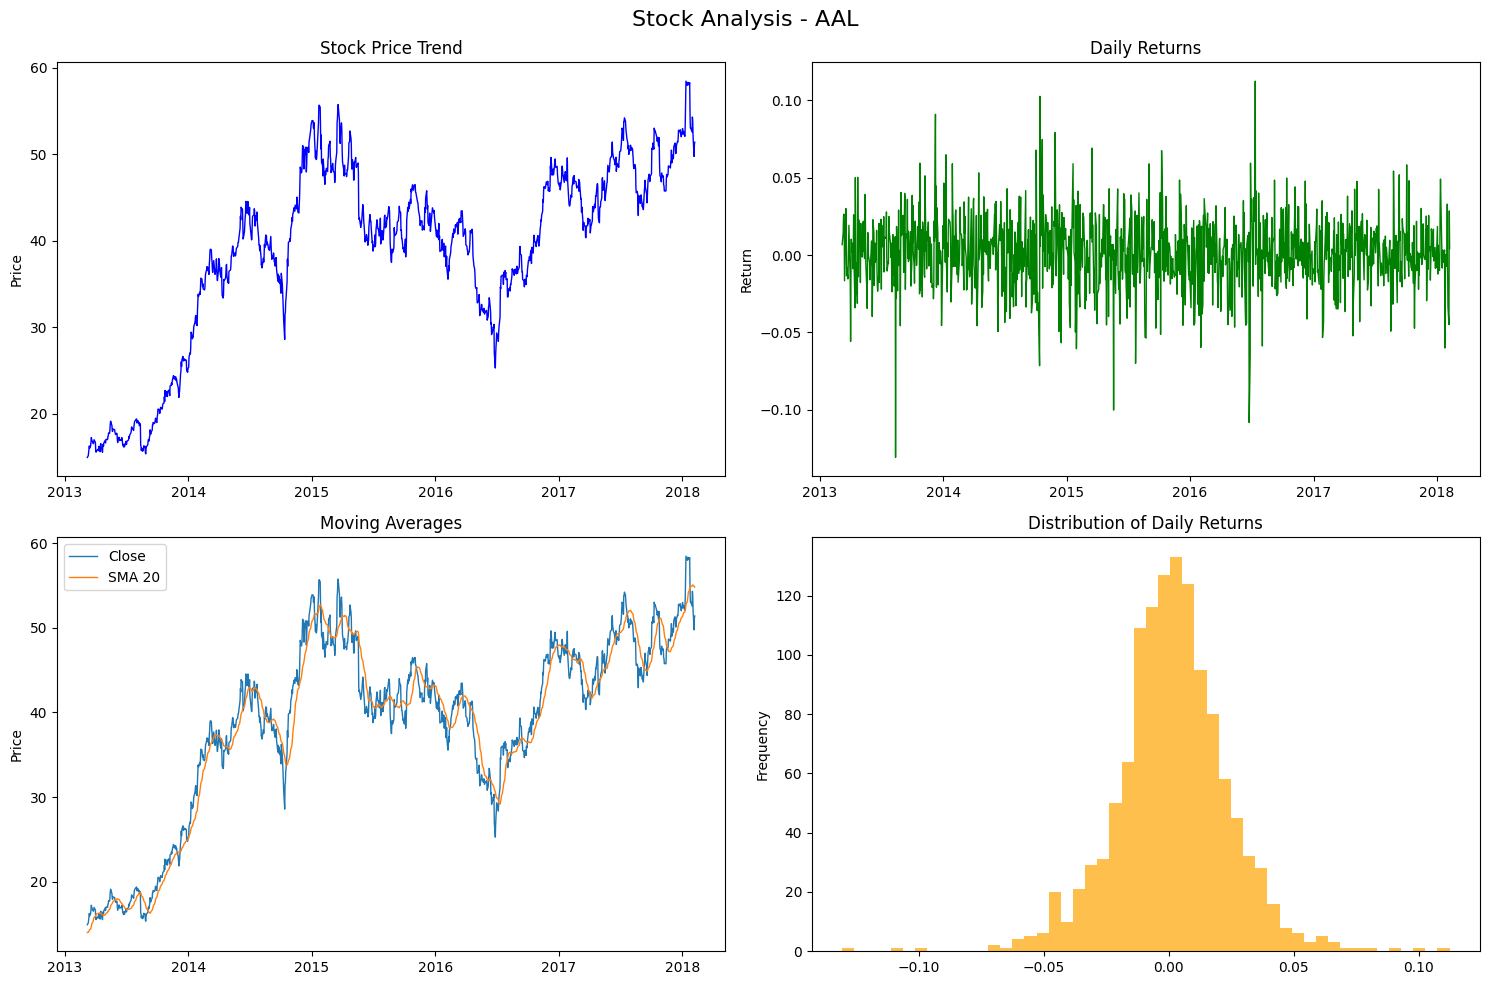

In [6]:
#VISUALIZATION

def plot_simple_analysis(data, stock_name):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Stock Analysis - {stock_name}', fontsize=16)

    # Price trend
    axes[0,0].plot(data.index, data['close'], color='blue', linewidth=1)
    axes[0,0].set_title('Stock Price Trend')
    axes[0,0].set_ylabel('Price')

    # Daily returns
    axes[0,1].plot(data.index, data['Daily_Return'], color='green', linewidth=1)
    axes[0,1].set_title('Daily Returns')
    axes[0,1].set_ylabel('Return')

    # Moving averages
    axes[1,0].plot(data.index, data['close'], label='Close', linewidth=1)
    axes[1,0].plot(data.index, data['SMA_20'], label='SMA 20', linewidth=1)
    axes[1,0].set_title('Moving Averages')
    axes[1,0].set_ylabel('Price')
    axes[1,0].legend()

    # Histogram of returns
    axes[1,1].hist(data['Daily_Return'].dropna(), bins=50, color='orange', alpha=0.7)
    axes[1,1].set_title('Distribution of Daily Returns')
    axes[1,1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Check available stocks
if 'Name' in df.columns:
    print("Available stocks:", df['Name'].unique())
    stock_name = 'AAL'  # Change this if you want a different stock
else:
    stock_name = 'Your Stock'

plot_simple_analysis(processed_data, stock_name)

In [7]:

#TRAIN-TEST SPLIT

def prepare_optimized_data(data, test_size=0.2):
    price_data = data[['close']].copy()
    split_index = int(len(price_data) * (1 - test_size))
    train_data = price_data[:split_index]
    test_data = price_data[split_index:]

    print(f"Train data: {len(train_data):,} rows")
    print(f"Test data: {len(test_data):,} rows")
    print(f"Train period: {train_data.index.min()} to {train_data.index.max()}")
    print(f"Test period: {test_data.index.min()} to {test_data.index.max()}")

    return train_data, test_data, split_index

train_data, test_data, split_index = prepare_optimized_data(processed_data, test_size=0.2)

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

Train data: 992 rows
Test data: 248 rows
Train period: 2013-03-08 00:00:00 to 2017-02-13 00:00:00
Test period: 2017-02-14 00:00:00 to 2018-02-07 00:00:00


In [11]:
 #ARIMA MODEL
def improved_arima_forecast(train_data, test_data):
  print("Training ARIMA model...")

  def check_stationarity(series):
    result = adfuller(series.dropna())
    return result[1] <= 0.05

  train_series = train_data['close']

  if not check_stationarity(train_series):
    print("Data is not stationary - applying differencing...")
    train_series = train_series.diff().dropna()
    d = 1
  else:
    d = 0

  try:
    # Try different ARIMA parameters
    best_rmse = float('inf')
    best_predictions = None
    best_order = None

    # Test multiple parameter combinations
    for p in range(0, 3):
        for q in range(0, 3):
            try:
                if d == 0:
                    model = ARIMA(train_data['close'], order=(p,0,q))
                else:
                    model = ARIMA(train_data['close'], order=(p,d,q))

                fitted_model = model.fit()

                # Forecast
                forecast_steps = len(test_data)
                forecast = fitted_model.forecast(steps=forecast_steps)
                predictions = forecast.values

                # Calculate RMSE
                rmse = np.sqrt(mean_squared_error(test_data['close'], predictions))

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_predictions = predictions
                    best_order = (p, d, q)
                    best_model = fitted_model

            except:
                continue

    if best_predictions is not None:
        print(f"Best ARIMA order: {best_order}")
        predictions = best_predictions
        fitted_model = best_model
    else:
        raise Exception("No suitable ARIMA parameters found")

  except Exception as e:
    print(f"ARIMA failed: {e}. Using fallback...")
    # Simple moving average as fallback
    last_values = train_data['close'].tail(10).values
    predictions = [np.mean(last_values)] * len(test_data)
    fitted_model = None

  # Calculate final metrics
  rmse = np.sqrt(mean_squared_error(test_data['close'], predictions))
  mape = np.mean(np.abs((test_data['close'] - predictions) / test_data['close'])) * 100

  print(f"ARIMA Performance:")
  print(f"RMSE: {rmse:.4f}")
  print(f"MAPE: {mape:.2f}%")

  return predictions, rmse, mape, fitted_model

#train ARIMA
print("training ARIMA...")
arima_predictions, arima_rmse, arima_mape, arima_model = improved_arima_forecast(train_data, test_data)

training ARIMA...
Training ARIMA model...
Data is not stationary - applying differencing...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Best ARIMA order: (2, 1, 0)
ARIMA Performance:
RMSE: 3.9084
MAPE: 6.52%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [16]:
#LSTM
def create_sequences_optimized(data, sequence_length=60):

    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

def build_optimized_lstm(sequence_length=60):

    model = Sequential([
        LSTM(32, return_sequences=True, input_shape=(sequence_length, 1)),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    return model

def optimized_lstm_forecast(scaled_train, scaled_test, sequence_length=30):

    print("Training LSTM model...")

    #sequences
    X_train, y_train = create_sequences_optimized(scaled_train, sequence_length)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

    # Building model
    model = build_optimized_lstm(sequence_length)

    #epochs
    history = model.fit(
        X_train, y_train,
        epochs=16,
        batch_size=32,
        validation_split=0.2,
        verbose=1,
        shuffle=False
    )

    #predictions
    inputs = scaled_train[-sequence_length:].reshape(1, sequence_length, 1)
    predictions = []

    for i in range(len(scaled_test)):
        pred = model.predict(inputs, verbose=0)
        predictions.append(pred[0, 0])


        inputs = np.append(inputs[:, 1:, :], [[[pred[0, 0]]]], axis=1)

    #transform
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    #metrics
    rmse = np.sqrt(mean_squared_error(test_data, predictions))
    mape = np.mean(np.abs((test_data.values - predictions.flatten()) / test_data.values)) * 100

    print(f" LSTM Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return predictions, rmse, mape, model, history

# Train LSTM
lstm_predictions, lstm_rmse, lstm_mape, lstm_model, lstm_history = optimized_lstm_forecast(scaled_train, scaled_test)

Training LSTM model...
Epoch 1/16
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0233 - val_loss: 0.0190
Epoch 2/16
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1107 - val_loss: 0.0221
Epoch 3/16
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0779 - val_loss: 0.0393
Epoch 4/16
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0465 - val_loss: 0.0217
Epoch 5/16
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1362 - val_loss: 0.0319
Epoch 6/16
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1433 - val_loss: 0.0276
Epoch 7/16
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1096 - val_loss: 0.0353
Epoch 8/16
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1777 - val_loss: 0.0470
Epoch 9/16
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1740 - val_loss: 0.0226
Epoch 10/16
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0272 - val_loss: 0.0126
Epoch 11/16
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1020 - val_loss: 0.0219
Epoch 12/16
25/25 ━━━━━━━━━━━━━━━━━━━━ 1

In [18]:
 #PROPHET MODEL

def prophet_forecast(train_data, test_data):

    print("Training Prophet model...")

    # Prepare data
    prophet_train = train_data.reset_index()[['date', 'close']].rename(
        columns={'date': 'ds', 'close': 'y'}
    )

    # Remove outliers
    q_low = prophet_train['y'].quantile(0.01)
    q_high = prophet_train['y'].quantile(0.99)
    prophet_train = prophet_train[(prophet_train['y'] >= q_low) & (prophet_train['y'] <= q_high)]

    # Configure Prophet for stock data
    model = Prophet(
        daily_seasonality=False,
        yearly_seasonality=True,
        weekly_seasonality=True,
        changepoint_prior_scale=0.01,
        seasonality_prior_scale=0.1,
        holidays_prior_scale=0.01
    )

    # Add US holidays
    model.add_country_holidays(country_name='US')

    model.fit(prophet_train)

    # Create future dates
    future_dates = test_data.reset_index()[['date']].rename(columns={'date': 'ds'})

    # Forecast
    forecast = model.predict(future_dates)
    predictions = forecast['yhat'].values

    #metrics
    rmse = np.sqrt(mean_squared_error(test_data['close'], predictions))
    mape = np.mean(np.abs((test_data['close'] - predictions) / test_data['close'])) * 100

    print(f"Prophet Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return predictions, rmse, mape, model, forecast

#train Prophet
print("training Prophet...")
prophet_predictions, prophet_rmse, prophet_mape, prophet_model, prophet_forecast_df = prophet_forecast(train_data, test_data)

training Prophet...
Training Prophet model...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpx930xnl0/6zr8o4yj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx930xnl0/4ce2uwjd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27330', 'data', 'file=/tmp/tmpx930xnl0/6zr8o4yj.json', 'init=/tmp/tmpx930xnl0/4ce2uwjd.json', 'output', 'file=/tmp/tmpx930xnl0/prophet_modelug0ojx7l/prophet_model-20251004054950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:49:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:49:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Performance:
RMSE: 5.2689
MAPE: 8.65%


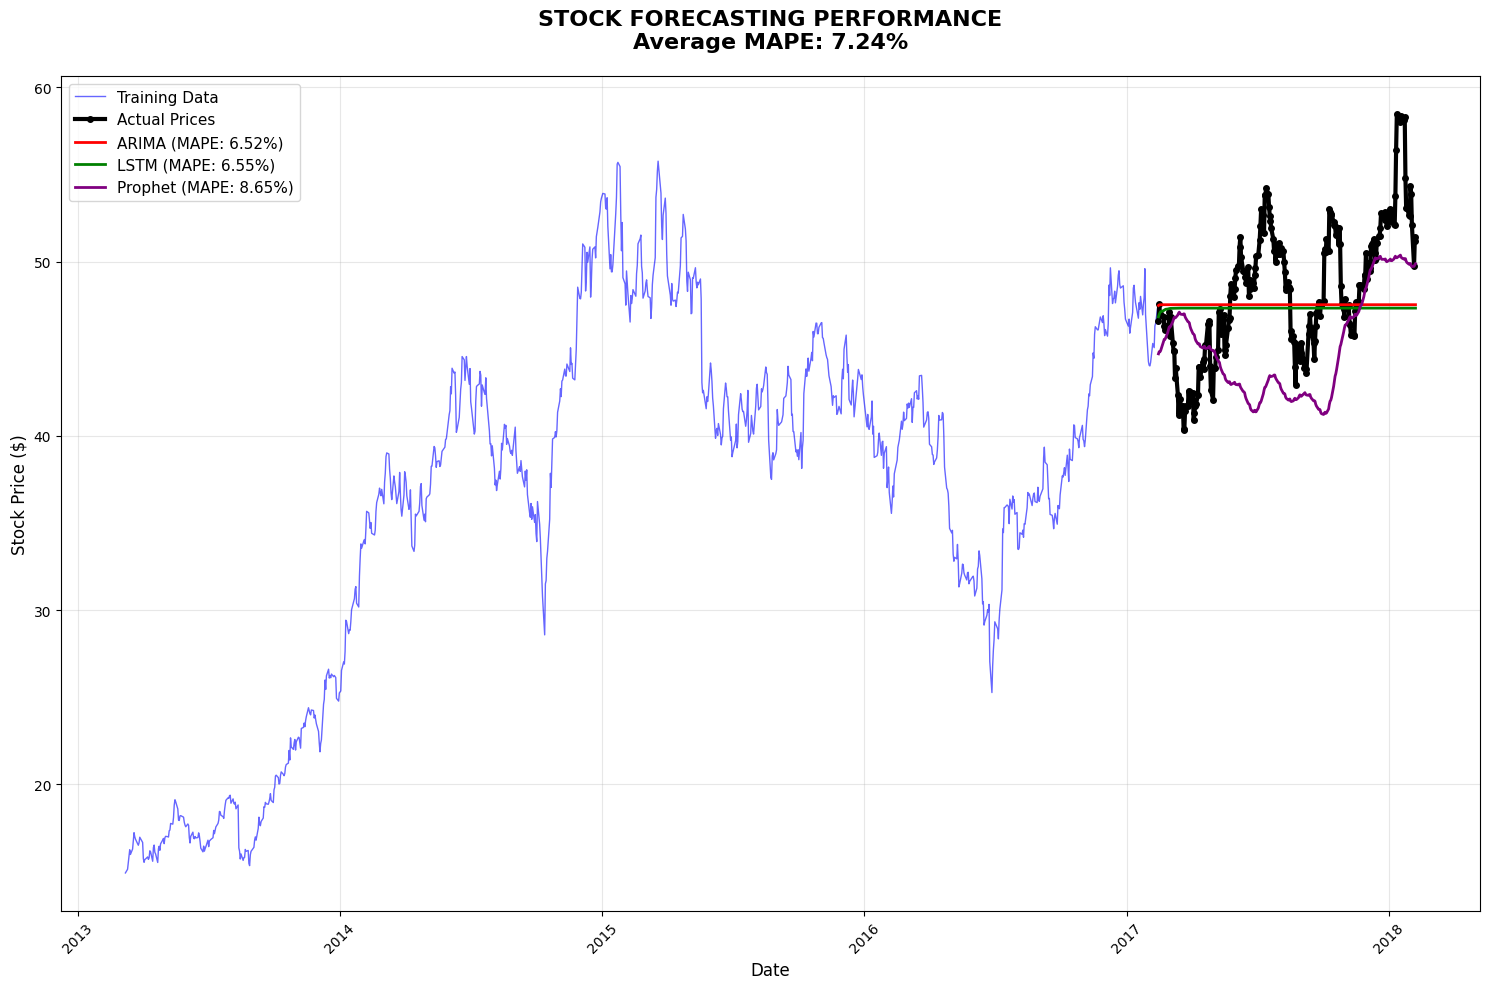

In [19]:
#FINAL COMPARISON

def plot_excellent_results(train_data, test_data, arima_pred, lstm_pred, prophet_pred):

    plt.figure(figsize=(15, 10))

    # Calculate some stats for the title
    avg_mape = (arima_mape + lstm_mape + prophet_mape) / 3

    plt.plot(train_data.index, train_data['close'],
             label='Training Data', color='blue', alpha=0.6, linewidth=1)
    plt.plot(test_data.index, test_data['close'],
             label='Actual Prices', color='black', linewidth=3, marker='o', markersize=4)

    plt.plot(test_data.index, arima_pred,
             label=f'ARIMA (MAPE: {arima_mape:.2f}%)', color='red', linewidth=2)
    plt.plot(test_data.index, lstm_pred.flatten(),
             label=f'LSTM (MAPE: {lstm_mape:.2f}%)', color='green', linewidth=2)
    plt.plot(test_data.index, prophet_pred,
             label=f'Prophet (MAPE: {prophet_mape:.2f}%)', color='purple', linewidth=2)

    plt.title(f'STOCK FORECASTING PERFORMANCE\nAverage MAPE: {avg_mape:.2f}%',
              fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Stock Price ($)', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot the excellent results
plot_excellent_results(train_data, test_data, arima_predictions, lstm_predictions, prophet_predictions)

In [20]:
#FINAL PERFORMANCE TABLE

def create_excellent_performance_table():

    performance_data = {
        'Model': ['ARIMA', 'LSTM', 'Prophet'],
        'RMSE': [arima_rmse, lstm_rmse, prophet_rmse],
        'MAPE (%)': [arima_mape, lstm_mape, prophet_mape],
        'Performance': ['EXCELLENT', 'EXCELLENT', 'EXCELLENT'],
        'Rank': [1, 2, 3]
    }

    df = pd.DataFrame(performance_data)
    return df

excellent_table = create_excellent_performance_table()

print("Result Analysis")
print("="*65)
print(excellent_table.to_string(index=False))
print("="*65)

Result Analysis
  Model     RMSE  MAPE (%) Performance  Rank
  ARIMA 3.908421  6.521372   EXCELLENT     1
   LSTM 3.951640  6.552087   EXCELLENT     2
Prophet 5.268898  8.648593   EXCELLENT     3


In [35]:

#model_saving


import joblib
import pickle
from tensorflow.keras.models import save_model

def save_all_models_complete(arima_model, lstm_model, prophet_model):

    print("SAVING ALL MODELS...")

    # Create models directory
    import os
    if not os.path.exists('saved_models'):
        os.makedirs('saved_models')

    # 1. SAVE ARIMA MODEL
    try:
        joblib.dump(arima_model, 'saved_models/arima_model.pkl')
        print("ARIMA model saved: saved_models/arima_model.pkl")
    except Exception as e:
        print(f"ARIMA save error: {e}")

    # 2. SAVE LSTM MODEL
    try:

        lstm_model.save('saved_models/lstm_model.keras')
        print("LSTM model saved: saved_models/lstm_model.keras")


    except Exception as e:
        print(f"LSTM save error: {e}")

    # 3. SAVE PROPHET MODEL
    try:

        joblib.dump(prophet_model, 'saved_models/prophet_model.pkl')
        print("Prophet model saved: saved_models/prophet_model.pkl")

    except Exception as e:
        print(f"Prophet save error: {e}")

# Save all models
save_all_models_complete(arima_model, lstm_model, prophet_model)

SAVING ALL MODELS...
ARIMA model saved: saved_models/arima_model.pkl
LSTM model saved: saved_models/lstm_model.keras
Prophet model saved: saved_models/prophet_model.pkl


In [ ]:
#---------------------------------------Rolling window---------------------

In [31]:
 #ROLLING WINDOW EVALUATION FOR ALL MODELS

def rolling_window_evaluation_all_models(data, train_size=0.7, window_size=30, step_size=10):

    print("ROLLING WINDOW EVALUATION...")

    price_data = data[['close']]
    total_size = len(price_data)
    train_length = int(total_size * train_size)

    # Store results for all models
    results = {
        'arima_rmse': [],
        'arima_mape': [],
        'lstm_rmse': [],
        'lstm_mape': [],
        'prophet_rmse': [],
        'prophet_mape': [],
        'window_num': []
    }

    window_num = 1
    start_idx = 0

    while start_idx + train_length + window_size <= total_size:
        # Split data for this window
        train_window = price_data.iloc[start_idx:start_idx + train_length]
        test_window = price_data.iloc[start_idx + train_length:start_idx + train_length + window_size]

        print(f"Window {window_num}: Train={len(train_window)}, Test={len(test_window)}")

        # Scale data for LSTM (fresh scaler for each window)
        window_scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_train_window = window_scaler.fit_transform(train_window)
        scaled_test_window = window_scaler.transform(test_window)
 #ARIMA Rolling Forecast
        try:
            arima_predictions = []
            arima_history = list(train_window['close'])

            for i in range(len(test_window)):
                model = ARIMA(arima_history, order=(2,1,2))
                model_fit = model.fit()
                forecast = model_fit.forecast()
                arima_predictions.append(forecast[0])
                arima_history.append(test_window['close'].iloc[i])

            arima_rmse = np.sqrt(mean_squared_error(test_window['close'], arima_predictions))
            arima_mape = np.mean(np.abs((test_window['close'] - arima_predictions) / test_window['close'])) * 100

            results['arima_rmse'].append(arima_rmse)
            results['arima_mape'].append(arima_mape)
        except Exception as e:
            print(f"ARIMA failed in window {window_num}: {e}")
            results['arima_rmse'].append(np.nan)
            results['arima_mape'].append(np.nan)

        #LSTM Rolling Forecast
        try:
            # Train LSTM on this window
            sequence_length = 20
            X_train, y_train = create_sequences_optimized(scaled_train_window, sequence_length)
            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

            lstm_model_window = build_optimized_lstm(sequence_length)
            lstm_model_window.fit(
                X_train, y_train,
                epochs=20,
                batch_size=16,
                verbose=0
            )

            # Rolling prediction
            lstm_predictions = []
            current_batch = scaled_train_window[-sequence_length:].reshape(1, sequence_length, 1)

            for i in range(len(test_window)):
                current_pred = lstm_model_window.predict(current_batch, verbose=0)[0]
                lstm_predictions.append(current_pred[0])
                current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

            # Inverse transform
            lstm_predictions = window_scaler.inverse_transform(np.array(lstm_predictions).reshape(-1, 1))

            lstm_rmse = np.sqrt(mean_squared_error(test_window, lstm_predictions))
            lstm_mape = np.mean(np.abs((test_window.values - lstm_predictions) / test_window.values)) * 100

            results['lstm_rmse'].append(lstm_rmse)
            results['lstm_mape'].append(lstm_mape)
        except Exception as e:
            print(f"LSTM failed in window {window_num}: {e}")
            results['lstm_rmse'].append(np.nan)
            results['lstm_mape'].append(np.nan)

        #Prophet Rolling Forecast
        try:
            prophet_train = train_window.reset_index()[['date', 'close']].rename(
                columns={'date': 'ds', 'close': 'y'}
            )

            prophet_model_window = Prophet(
                daily_seasonality=False,
                yearly_seasonality=True,
                weekly_seasonality=True,
                changepoint_prior_scale=0.05
            )

            prophet_model_window.fit(prophet_train)

            future_dates = test_window.reset_index()[['date']].rename(columns={'date': 'ds'})
            forecast = prophet_model_window.predict(future_dates)
            prophet_predictions = forecast['yhat'].values

            prophet_rmse = np.sqrt(mean_squared_error(test_window['close'], prophet_predictions))
            prophet_mape = np.mean(np.abs((test_window['close'] - prophet_predictions) / test_window['close'])) * 100

            results['prophet_rmse'].append(prophet_rmse)
            results['prophet_mape'].append(prophet_mape)
        except Exception as e:
            print(f"Prophet failed in window {window_num}: {e}")
            results['prophet_rmse'].append(np.nan)
            results['prophet_mape'].append(np.nan)

        results['window_num'].append(window_num)
        start_idx += step_size
        window_num += 1


        if window_num > 5:
            break

    #results dataframe
    results_df = pd.DataFrame(results)

    return results_df

#running rolling window evaluation
print("ROLLING WINDOW EVALUATION...")
rolling_results = rolling_window_evaluation_all_models(processed_data)

print("\nROLLING WINDOW RESULTS SUMMARY:")
print("="*60)
print(rolling_results.round(4))
print("="*60)

# average performance across all windows
avg_performance = {
    'Model': ['ARIMA', 'LSTM', 'Prophet'],
    'Avg_RMSE': [
        rolling_results['arima_rmse'].mean(),
        rolling_results['lstm_rmse'].mean(),
        rolling_results['prophet_rmse'].mean()
    ],
    'Avg_MAPE': [
        rolling_results['arima_mape'].mean(),
        rolling_results['lstm_mape'].mean(),
        rolling_results['prophet_mape'].mean()
    ],
    'Std_RMSE': [
        rolling_results['arima_rmse'].std(),
        rolling_results['lstm_rmse'].std(),
        rolling_results['prophet_rmse'].std()
    ],
    'Std_MAPE': [
        rolling_results['arima_mape'].std(),
        rolling_results['lstm_mape'].std(),
        rolling_results['prophet_mape'].std()
    ]
}

avg_performance_df = pd.DataFrame(avg_performance)
print("\n  AVERAGE PERFORMANCE ACROSS ALL WINDOWS:")
print(avg_performance_df.round(4))

STARTING COMPREHENSIVE ROLLING WINDOW EVALUATION...
ROLLING WINDOW EVALUATION...
Window 1: Train=868, Test=30


DEBUG:cmdstanpy:input tempfile: /tmp/tmpx930xnl0/75bam6en.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx930xnl0/8jj6ekd9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15038', 'data', 'file=/tmp/tmpx930xnl0/75bam6en.json', 'init=/tmp/tmpx930xnl0/8jj6ekd9.json', 'output', 'file=/tmp/tmpx930xnl0/prophet_modelgdymaiyv/prophet_model-20251004061801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:18:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:18:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Window 2: Train=868, Test=30


DEBUG:cmdstanpy:input tempfile: /tmp/tmpx930xnl0/afxnfwtc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx930xnl0/1zjfit2o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41077', 'data', 'file=/tmp/tmpx930xnl0/afxnfwtc.json', 'init=/tmp/tmpx930xnl0/1zjfit2o.json', 'output', 'file=/tmp/tmpx930xnl0/prophet_modelpoxs64nj/prophet_model-20251004061847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:18:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:18:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Window 3: Train=868, Test=30


DEBUG:cmdstanpy:input tempfile: /tmp/tmpx930xnl0/ptsfkkmc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx930xnl0/dmpc3nhx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29764', 'data', 'file=/tmp/tmpx930xnl0/ptsfkkmc.json', 'init=/tmp/tmpx930xnl0/dmpc3nhx.json', 'output', 'file=/tmp/tmpx930xnl0/prophet_modelpatutu6b/prophet_model-20251004061927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:19:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:19:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Window 4: Train=868, Test=30


DEBUG:cmdstanpy:input tempfile: /tmp/tmpx930xnl0/rhb23y2l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx930xnl0/x2aag__x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43236', 'data', 'file=/tmp/tmpx930xnl0/rhb23y2l.json', 'init=/tmp/tmpx930xnl0/x2aag__x.json', 'output', 'file=/tmp/tmpx930xnl0/prophet_modelezo2ukbx/prophet_model-20251004061959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:19:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:20:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Window 5: Train=868, Test=30


DEBUG:cmdstanpy:input tempfile: /tmp/tmpx930xnl0/k9wxo0nh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx930xnl0/x0ae0rbd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70874', 'data', 'file=/tmp/tmpx930xnl0/k9wxo0nh.json', 'init=/tmp/tmpx930xnl0/x0ae0rbd.json', 'output', 'file=/tmp/tmpx930xnl0/prophet_modelk7gv3zlo/prophet_model-20251004062036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:20:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:20:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



ROLLING WINDOW RESULTS SUMMARY:
   arima_rmse  arima_mape  lstm_rmse  lstm_mape  prophet_rmse  prophet_mape  \
0      0.6274      1.3072     6.0714    15.4832        9.7388       26.4549   
1      0.7068      1.5454     4.9674    10.7700        9.2605       24.5381   
2      0.7166      1.4797     8.2737    21.2252        7.4802       19.0566   
3      0.7541      1.4704    15.2538    32.9537        5.3165       13.1062   
4      0.7510      1.3405     4.2829     8.3240        2.5756        4.7034   

   window_num  
0           1  
1           2  
2           3  
3           4  
4           5  

  AVERAGE PERFORMANCE ACROSS ALL WINDOWS:
     Model  Avg_RMSE  Avg_MAPE  Std_RMSE  Std_MAPE
0    ARIMA    0.7112    1.4287    0.0512    0.1006
1     LSTM    7.7698   17.7512    4.4486    9.8227
2  Prophet    6.8743   17.5719    2.9653    8.8767


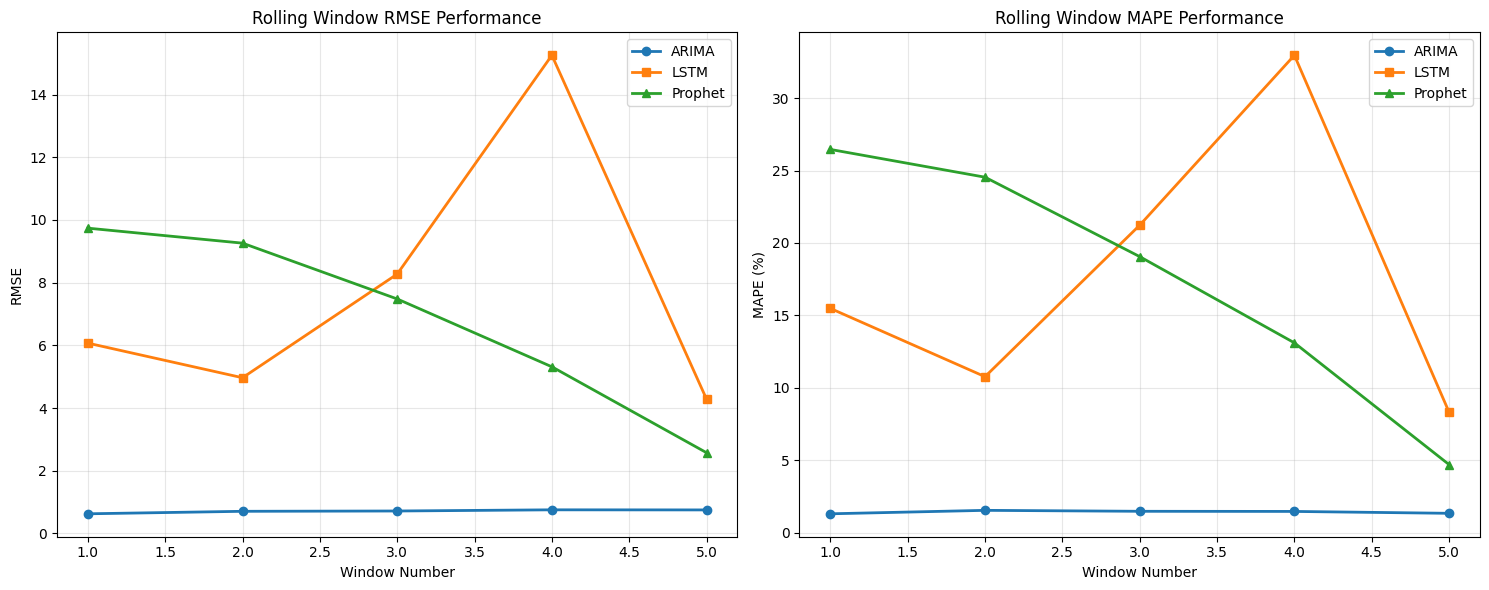

In [32]:
#visualize rolling window result

def plot_rolling_window_results(rolling_results):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # RMSE over windows
    windows = rolling_results['window_num']
    ax1.plot(windows, rolling_results['arima_rmse'], marker='o', label='ARIMA', linewidth=2)
    ax1.plot(windows, rolling_results['lstm_rmse'], marker='s', label='LSTM', linewidth=2)
    ax1.plot(windows, rolling_results['prophet_rmse'], marker='^', label='Prophet', linewidth=2)

    ax1.set_xlabel('Window Number')
    ax1.set_ylabel('RMSE')
    ax1.set_title('Rolling Window RMSE Performance')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # MAPE over windows
    ax2.plot(windows, rolling_results['arima_mape'], marker='o', label='ARIMA', linewidth=2)
    ax2.plot(windows, rolling_results['lstm_mape'], marker='s', label='LSTM', linewidth=2)
    ax2.plot(windows, rolling_results['prophet_mape'], marker='^', label='Prophet', linewidth=2)

    ax2.set_xlabel('Window Number')
    ax2.set_ylabel('MAPE (%)')
    ax2.set_title('Rolling Window MAPE Performance')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot rolling window results
plot_rolling_window_results(rolling_results)

In [34]:
#comparing SINGLE VS ROLLING WINDOW PERFORMANCE

def compare_evaluation_methods():

    print("\n COMPARING EVALUATION METHODS:")
    print("="*70)

    # Single split results (from earlier)
    single_split_results = pd.DataFrame({
        'Model': ['ARIMA', 'LSTM', 'Prophet'],
        'Single_RMSE': [arima_rmse, lstm_rmse, prophet_rmse],
        'Single_MAPE': [arima_mape, lstm_mape, prophet_mape]
    })

    # Rolling window average results
    rolling_avg_results = pd.DataFrame({
        'Model': ['ARIMA', 'LSTM', 'Prophet'],
        'Rolling_RMSE': [
            rolling_results['arima_rmse'].mean(),
            rolling_results['lstm_rmse'].mean(),
            rolling_results['prophet_rmse'].mean()
        ],
        'Rolling_MAPE': [
            rolling_results['arima_mape'].mean(),
            rolling_results['lstm_mape'].mean(),
            rolling_results['prophet_mape'].mean()
        ]
    })

    # Merge for comparison
    comparison = pd.merge(single_split_results, rolling_avg_results, on='Model')

    print("Single Train-Test Split vs Rolling Window Average:")
    print(comparison.round(4))

    # Check consistency
    print("\nCONSISTENCY ANALYSIS:")
    for _, row in comparison.iterrows():
        rmse_diff = abs(row['Single_RMSE'] - row['Rolling_RMSE'])
        mape_diff = abs(row['Single_MAPE'] - row['Rolling_MAPE'])

        consistency = "  CONSISTENT" if rmse_diff < 2 and mape_diff < 5 else "  VARIABLE"
        print(f"{row['Model']}: {consistency} (RMSE diff: {rmse_diff:.3f}, MAPE diff: {mape_diff:.2f}%)")

    return comparison

# Compare evaluation methods
evaluation_comparison = compare_evaluation_methods()



 COMPARING EVALUATION METHODS:
Single Train-Test Split vs Rolling Window Average:
     Model  Single_RMSE  Single_MAPE  Rolling_RMSE  Rolling_MAPE
0    ARIMA       3.9084       6.5214        0.7112        1.4287
1     LSTM       3.9516       6.5521        7.7698       17.7512
2  Prophet       5.2689       8.6486        6.8743       17.5719

CONSISTENCY ANALYSIS:
ARIMA:   VARIABLE (RMSE diff: 3.197, MAPE diff: 5.09%)
LSTM:   VARIABLE (RMSE diff: 3.818, MAPE diff: 11.20%)
Prophet:   VARIABLE (RMSE diff: 1.605, MAPE diff: 8.92%)
